In [1]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.models import Sequential
from keras.layers import Activation
# import theano.tensor as T
from keras import backend as K
import tensorflow as tf
from sklearn.model_selection import train_test_split as split
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from keras.callbacks import EarlyStopping
from sklearn.mixture import GaussianMixture as GM
from math import radians, cos, sin, asin, sqrt
from sklearn.externals import joblib
from sklearn.cluster import KMeans
import math
from keras.models import load_model
from keras.applications import imagenet_utils
from importlib import reload
import h5py as h5py
import matplotlib.cm as cm

Using TensorFlow backend.


In [2]:
# # gaussian Mixture
# # criticalFind is list of critical features

# def seperateCluster(clusterNum, train, covtype, criticalFind):
# #     print(train.shape)
#     X = train[:, criticalFind]
#     Y = train[:, -2:]
#     n = X.shape[0]
# #     kmeans = KMeans(n_clusters=clusterNum, random_state=0).fit(X)
# #     labels = kmeans.labels_

#     gm = GM(n_components=clusterNum, covariance_type = covtype).fit(X)
#     labels = gm.predict(X)
#     classDic = {}
#     for i in range(clusterNum):
#         classDic[i] = []

#     for i in range(n):
#         c = labels[i]
#         classDic[c].append(train[i, :])
        
#     print('Train Clusters Shape')
#     for i in classDic:
#         matrix = np.vstack(classDic[i])
#         classDic[i] = matrix
#         print(matrix.shape)
# #         np.savetxt(str(clusterNum) + 'clustersNum' + str(i) + '.txt', matrix)
#     return (gm, classDic)

In [3]:
# category is 'Train' or 'Validation' or 'Test', just for title

def plotPrediction(ytrue, ypred, clusterInd, category = 'Train'):
    Y_p = ypred
    Y_v = ytrue
#     plt.title('Prediction for Cluster ' + str(clusterInd) + ' ' + category + ' Data')
    plt.subplot(3,1,1)
    bm=Basemap()
    bm.drawcoastlines(linewidth=0.5)
    bm.drawmeridians(np.arange(0,360,30))
    bm.drawparallels(np.arange(-90,90,30))
    #Y_p=predict(X,m_l,W,b)
    #model=load_model('withpopulation_model_bigcircle.h5')
    #Y_p=model.predict(X_v)
    #Y_p[:,1]=Y_p[:,1]*360
    #Y_p[:,0]=Y_p[:,0]*180
    sort1=np.argsort(Y_v[:,1])

    N_v=np.shape(Y_p)[0]
    colors=[ cm.jet(x) for x in np.linspace(0.2,1,N_v) ]
    for i in range(N_v):
        if Y_v[sort1[i],1]>40:
            plt.plot(Y_v[sort1[i],1],Y_v[sort1[i],0],'x',color=colors[i],markersize=10)
            plt.plot(Y_p[sort1[i],1],Y_p[sort1[i],0],'o',color=colors[i],markersize=4)
    #plt.scatter(Y_v[:,1],Y_v[:,0])
    #plt.scatter(Y_p[:,1],Y_p[:,0])
    #plt.savefig('linear_regression_prediction1',dpi=300)

    #plt.clf()
    plt.subplot(3,1,2)
    bm=Basemap()
    bm.drawcoastlines(linewidth=0.5)
    bm.drawmeridians(np.arange(0,360,30))
    bm.drawparallels(np.arange(-90,90,30))
    for i in range(N_v):
        if Y_v[sort1[i],1]<40 and Y_v[sort1[i],1]>-30:
            plt.plot(Y_v[sort1[i],1],Y_v[sort1[i],0],'x',color=colors[i],markersize=10)
            plt.plot(Y_p[sort1[i],1],Y_p[sort1[i],0],'o',color=colors[i],markersize=4)
    #plt.scatter(Y_v[:,1],Y_v[:,0])
    #plt.scatter(Y_p[:,1],Y_p[:,0])
    #plt.savefig('linear_regression_prediction2',dpi=300)

    #plt.clf()
    plt.subplot(3,1,3)
    bm=Basemap()
    bm.drawcoastlines(linewidth=0.5)
    bm.drawmeridians(np.arange(0,360,30))
    bm.drawparallels(np.arange(-90,90,30))
    for i in range(N_v):
        if Y_v[sort1[i],1]<-30:
            plt.plot(Y_v[sort1[i],1],Y_v[sort1[i],0],'x',color=colors[i],markersize=10)
            plt.plot(Y_p[sort1[i],1],Y_p[sort1[i],0],'o',color=colors[i],markersize=4)

    plt.tight_layout()
    plt.savefig('pred' + category + 'Cluster' + str(clusterInd) + '.png',dpi=300)
    plt.show()

In [4]:
# kmeans
# criticalFind is list of critical features

def seperateCluster(clusterNum, train, covtype, criticalFind):
#     print(train.shape)
    X = train[:, criticalFind]
    Y = train[:, -2:]
    n = X.shape[0]
    kmeans = KMeans(n_clusters=clusterNum, n_init=1000).fit(X)
    labels = kmeans.labels_

#     gm = GM(n_components=clusterNum, covariance_type = covtype).fit(X)
#     labels = gm.predict(X)
    classDic = {}
    for i in range(clusterNum):
        classDic[i] = []

    for i in range(n):
        c = labels[i]
        classDic[c].append(train[i, :])
        
    print('Train Clusters Shape')
    for i in classDic:
        matrix = np.vstack(classDic[i])
        classDic[i] = matrix
        print(matrix.shape)
#         np.savetxt(str(clusterNum) + 'clustersNum' + str(i) + '.txt', matrix)
    return (kmeans, classDic)

In [5]:
def _loss_tensor(y_true, y_pred):
    #y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    #out=(y_true - y_pred)**2-bimix_gauss.prob(y_pred).eval(session=sess)
    B=np.genfromtxt('map_gaussian_mixture.txt',delimiter=',')
    ds = tf.contrib.distributions
    mix = list(B[:,-1])
    sigma=10.
    myc=[ds.MultivariateNormalDiag([B[0,0],B[0,1]], [B[0,2]/sigma,B[0,2]/sigma])]

    for i in range(59):
        myc.append(ds.MultivariateNormalDiag([B[i+1,0],B[i+1,1]], [B[i+1,2]/sigma,B[i+1,2]/sigma]))

    bimix_gauss = ds.Mixture(
      cat=ds.Categorical(probs=mix),
      components=myc)

    split0, split1 = tf.split(y_pred, num_or_size_splits=2, axis=-1)
    split3, split4 = tf.split(y_true, num_or_size_splits=2, axis=-1)
    out=6371*tf.asin(K.sin((split1 - split4)/(180*math.pi))**2+
                     K.cos(split1/(180*math.pi))*K.cos(split4/(180*math.pi))*K.sin((split3-split0)*0.5/(180*math.pi))**2)



#         out=(y_true - y_pred)**2
    out2=-0.3 * bimix_gauss.prob(y_pred)#.eval(session=sess)
    #out = -(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred))
    return K.mean(out, axis=-1)+K.mean(out2, axis=-1)

In [6]:
# lambd is the coefficient for density term
def nnCluster(clusterTrainData, clusterIndex, lambd, epochNum, batchSize, trainRatio):
    sess = tf.Session()
    K.set_session(sess)


#     def _loss_tensor(y_true, y_pred):
#         #y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
#         #out=(y_true - y_pred)**2-bimix_gauss.prob(y_pred).eval(session=sess)
#         B=np.genfromtxt('map_gaussian_mixture.txt',delimiter=',')
#         ds = tf.contrib.distributions
#         mix = list(B[:,-1])
#         sigma=10.
#         myc=[ds.MultivariateNormalDiag([B[0,0],B[0,1]], [B[0,2]/sigma,B[0,2]/sigma])]

#         for i in range(59):
#             myc.append(ds.MultivariateNormalDiag([B[i+1,0],B[i+1,1]], [B[i+1,2]/sigma,B[i+1,2]/sigma]))

#         bimix_gauss = ds.Mixture(
#           cat=ds.Categorical(probs=mix),
#           components=myc)
        
#         split0, split1 = tf.split(y_pred, num_or_size_splits=2, axis=-1)
#         split3, split4 = tf.split(y_true, num_or_size_splits=2, axis=-1)
#         out=6371*tf.asin(K.sin((split1 - split4)/(180*math.pi))**2+
#                          K.cos(split1/(180*math.pi))*K.cos(split4/(180*math.pi))*K.sin((split3-split0)*0.5/(180*math.pi))**2)

        
        
#         out=(y_true - y_pred)**2
#         out2=-0.2 * bimix_gauss.prob(y_pred)#.eval(session=sess)
#         #out = -(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred))
#         return K.mean(out, axis=-1)+K.mean(out2, axis=-1)

    model = Sequential([
        Dense(80, input_shape=(68,)),
        Activation('relu'),
        Dense(80),
        Activation('relu'),
#         Dense(80),
#         Activation('relu'),
        Dense(80),
        Activation('relu'),
        Dense(2),
        Activation('linear'),
    ])


    #model.compile(optimizer='rmsprop',
    #              loss='mean_squared_error',
    #              metrics=['accuracy'])
    model.compile(optimizer='rmsprop',
                  loss= _loss_tensor)

    
    A, C = split(clusterTrainData, train_size = trainRatio)

    N=np.shape(A)[0]
    m=np.shape(A)[1]

    X=A[:,0:-2]
    Y=A[:,-2:]
    X_v=C[:,0:-2]
    Y_v=C[:,-2:]
    # Train the model, iterating on the data in batches of 32 samples
    
#     early_stopping = EarlyStopping(monitor='val_loss', patience= 3)
#     model.fit(X, Y, epochs = epochNum, batch_size = batchSize, validation_data = (X_v, Y_v), callbacks=[early_stopping])
    
    model.fit(X, Y, epochs = epochNum, batch_size = batchSize)
    
    model.save('clusterWhole' + str(clusterIndex) + '.h5')
    

#     Y_p=model.predict(X)   # predict training data
    
    Y_p=model.predict(X_v)   # predict validation data

    Y_trp = model.predict(X)

    bm=Basemap()
    bm.drawcoastlines(linewidth=0.5)
    bm.drawmeridians(np.arange(0,360,30))
    bm.drawparallels(np.arange(-90,90,30))


#     plt.scatter(Y[:,1],Y[:,0])       # plot training location
    plt.scatter(Y_v[:, 1], Y_v[:, 0])   # plot validation location
    plt.scatter(Y_p[:,1],Y_p[:,0])
    plt.title('Validation Set Cluster ' + str(clusterIndex))
    plt.savefig('cluster' + str(clusterIndex) +  'Val.pdf', bbox_inches = 'tight')
    plt.show()
    
    plotPrediction(Y_v, Y_p, clusterIndex, category = 'Validation')
    
    bm=Basemap()
    bm.drawcoastlines(linewidth=0.5)
    bm.drawmeridians(np.arange(0,360,30))
    bm.drawparallels(np.arange(-90,90,30))


#     plt.scatter(Y[:,1],Y[:,0])       # plot training location
    plt.scatter(Y[:, 1], Y[:, 0])   # plot validation location
    plt.scatter(Y_trp[:,1],Y_trp[:,0])
    plt.title('Training Set Cluster ' + str(clusterIndex))
    plt.savefig('cluster' + str(clusterIndex) +  'Train.pdf', bbox_inches = 'tight')
    plt.show()
    
    plotPrediction(Y, Y_trp, clusterIndex, category = 'Train')
    
    return model

In [7]:
def predictClusterSep(clusterNum):
    totalDist = 0
    totalSize = 0
    for i in range(1, 2):
        print(i)
        modelfile = 'cluster' + str(i) + '.h5'
        model = load_model(modelfile, custom_objects={'_loss_tensor': _loss_tensor})
        testfile = 'test' + str(i) + '.txt'
        testData = np.loadtxt(testfile)
        size = testData.shape[0]
        totalSize += size
        X = testData[:, :-2]
        Y = testData[:, -2:]
        Yp = model.predict(X)
        dist = 0
        for j in range(size):
            dist += haversine(Y[i, :], Yp[i, :])
        aveDist = dist / size
        totalDist += dist
        print('cluster ' + str(i) + ' has ' + str(size) + ' points, average Distance is ' + str(aveDist))
        
        bm=Basemap()
        bm.drawcoastlines(linewidth=0.5)
        bm.drawmeridians(np.arange(0,360,30))
        bm.drawparallels(np.arange(-90,90,30))


    #     plt.scatter(Y[:,1],Y[:,0])       # plot training location
        plt.scatter(Y[:, 1], Y[:, 0], label = 'True')   # plot validation location
        plt.scatter(Yp[:,1],Yp[:,0], label = 'Predicted')
        plt.title('Test Set Cluster ' + str(i))
        plt.legend(loc = 'best')
        plt.savefig('cluster' + str(i) +  'Test.pdf', bbox_inches = 'tight')
        plt.show()
        
    totalAve = totalDist / totalSize
    print('Overall Average Distance is ' + str(totalAve))

        
            

In [8]:
# predictClusterSep(4)

In [9]:
# load Model:::NO DELETE

# newModel = load_model('cluster0.h5', custom_objects={'_loss_tensor': _loss_tensor})

In [10]:
def haversine(y1, y2): 
    """ 
    Calculate the great circle distance between two points  
    on the earth (specified in decimal degrees) 
    """    
    
    lon1 = y1[1]
    lat1 = y1[0]
    
    lon2 = y2[1]
    lat2 = y2[0]
    
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])  
  
    # haversine公式  
    dlon = lon2 - lon1   
    dlat = lat2 - lat1   
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2  
    c = 2 * asin(sqrt(a))   
    r = 6371 # 地球平均半径，单位为公里  
    return c * r 

In [11]:
def trainNN(clusterNum, train, covtype, criticalFind, 
           lambd, epochNum, batchSize, nnTrainValRatio):
    classifyModel, classDic = seperateCluster(clusterNum, train, covtype, criticalFind)
    print('Finish Clustering Training Data')
    nnConfig = []
    nnWeights = []
    for i in range(clusterNum):
        clusterTrainData = classDic[i]
        np.savetxt('cluster' + str(i) + 'train.txt', clusterTrainData)
        aNNmodel = nnCluster(clusterTrainData, i, lambd, epochNum, batchSize, nnTrainValRatio)
        nnConfig.append(aNNmodel.get_config())
        nnWeights.append(aNNmodel.get_weights())
        print('Finish Training NN for Cluster ' + str(i))
    print('Finish Training')
    return (classifyModel, nnConfig, nnWeights)

In [12]:
def testNN(testData, criticalFind, classifyModel, nnConfig, nnWeights):
    n = testData.shape[0]
    print('Number of test data points is ' + str(n))
    predict = []
    trueY = []
    totalDistance = 0
    testCluster = {}
    
    for i in range(n):
        clusterInd = int(classifyModel.predict(testData[i, criticalFind].reshape((1, len(criticalFind))))[0])
        if clusterInd not in testCluster:
            testCluster[clusterInd] = [testData[i, :]]
        else:
            testCluster[clusterInd].append(testData[i, :])
    print('Cluster Number in test data ' + str(len(testCluster)))        
    for ind in testCluster:
        print('Start predict cluster ' + str(ind))
        clusterData = testCluster[ind]
        clusterSize = len(clusterData)
        clusterData = np.vstack(clusterData)
        np.savetxt('cluster' + str(ind) + 'test.txt', clusterData)
        clusterDist = 0
        clusterPred = []
        clusterTrueY = []
#         print(clusterData.shape)
#         print(type(clusterData))
        
        sess = tf.Session()
        K.set_session(sess)
        print('Init ok')
        config = nnConfig[ind]
        weights = nnWeights[ind]
        amodel = Sequential.from_config(config)
        amodel.set_weights(weights)
        print('modelOk')
        for i in range(clusterSize):
            testx = clusterData[i, :-2].reshape((1, 68))
            
#             print(testx.shape)
            ypred = amodel.predict(testx)[0, :]
            y = clusterData[i, -2:]
            clusterPred.append(ypred)
            clusterTrueY.append(y)
            clusterDist += haversine(y , ypred)
            
        clusterPred = np.vstack(clusterPred)
        clusterTrueY = np.vstack(clusterTrueY)
        
        
            
        clusterAve = clusterDist / clusterSize
        print('Ave Dist in Cluster ' + str(ind) + ' is ' + str(clusterAve))
        plotPrediction(clusterTrueY, clusterPred, ind, category = 'Test')
        
        
        totalDistance += clusterDist
        predict.append(clusterPred)
        trueY.append(clusterTrueY)
        
    aveDist = totalDistance / n
    predictArray = np.vstack(predict) # change predictions to npArray, shape(test number, 2)
    trueYarray = np.vstack(trueY)
    return (aveDist, predictArray, trueYarray)
    

In [13]:
def trainTest(clusterNum, lambd, epochNum, batchSize, 
              trainFileName = 'train0.8.txt' , testFileName = 'test0.2.txt'):

    covtype = 'full'
    train_data = np.genfromtxt(trainFileName)
    criticalFind = list(range(68))
    classifyModel, nnConfig, nnWeights = trainNN(clusterNum, train_data, covtype, criticalFind, 
               lambd, epochNum , batchSize, nnTrainValRatio = 0.9)
    testData = np.genfromtxt(testFileName)
    aveDist, predictArray, trueYarray = testNN(testData, criticalFind, classifyModel, nnConfig, nnWeights)
    print('Finish Test')
    print('Average Distance is ' + str(aveDist))    
    return (aveDist, predictArray, trueYarray)

Train Clusters Shape
(172, 70)
(258, 70)
(292, 70)
(112, 70)
Finish Clustering Training Data


c:\users\yinan\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Epoch 1/55
154/154 [==============================] - 6s 40ms/step - loss: 87.4653
Epoch 2/55
154/154 [==============================] - 0s 507us/step - loss: 54.6779
Epoch 3/55
154/154 [==============================] - 0s 507us/step - loss: 42.5134
Epoch 4/55
154/154 [==============================] - 0s 507us/step - loss: 37.9764
Epoch 5/55
154/154 [==============================] - 0s 609us/step - loss: 34.9606
Epoch 6/55
154/154 [==============================] - 0s 609us/step - loss: 32.0908
Epoch 7/55
154/154 [==============================] - 0s 507us/step - loss: 29.7584
Epoch 8/55
154/154 [==============================] - 0s 644us/step - loss: 27.0615
Epoch 9/55
154/154 [==============================] - 0s 451us/step - loss: 25.3475
Epoch 10/55
154/154 [==============================] - 0s 507us/step - loss: 23.3055
Epoch 11/55
154/154 [==============================] - 0s 609us/step - loss: 21.6491
Epoch 12/55
154/154 [==============================] - 0s 507us/step - loss

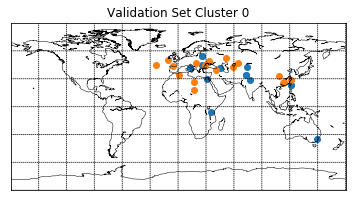

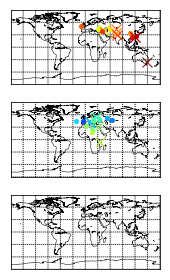

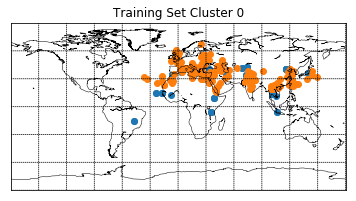

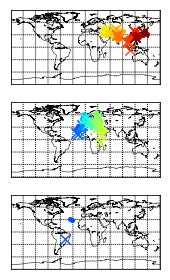

Finish Training NN for Cluster 0
Epoch 1/55
232/232 [==============================] - 10s 43ms/step - loss: 75.5741
Epoch 2/55
232/232 [==============================] - 0s 660us/step - loss: 67.8530
Epoch 3/55
232/232 [==============================] - 0s 653us/step - loss: 62.2820
Epoch 4/55
232/232 [==============================] - 0s 654us/step - loss: 59.1463
Epoch 5/55
232/232 [==============================] - 0s 631us/step - loss: 56.2320
Epoch 6/55
232/232 [==============================] - 0s 708us/step - loss: 52.9593
Epoch 7/55
232/232 [==============================] - 0s 660us/step - loss: 49.4646
Epoch 8/55
232/232 [==============================] - 0s 636us/step - loss: 45.7073
Epoch 9/55
232/232 [==============================] - 0s 636us/step - loss: 42.0594
Epoch 10/55
232/232 [==============================] - 0s 702us/step - loss: 38.9049
Epoch 11/55
232/232 [==============================] - 0s 652us/step - loss: 36.3149
Epoch 12/55
232/232 [====================

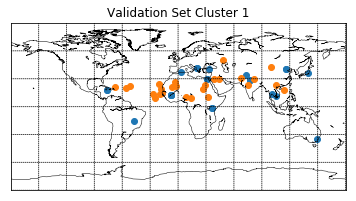

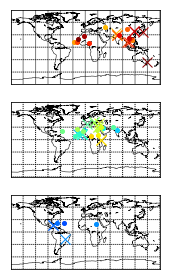

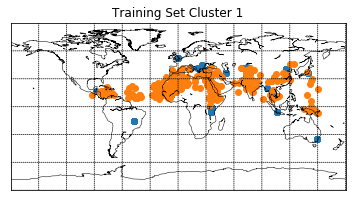

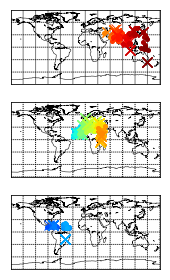

Finish Training NN for Cluster 1
Epoch 1/55
262/262 [==============================] - 14s 53ms/step - loss: 56.2318
Epoch 2/55
262/262 [==============================] - 0s 623us/step - loss: 39.9583
Epoch 3/55
262/262 [==============================] - 0s 642us/step - loss: 36.9278
Epoch 4/55
262/262 [==============================] - 0s 642us/step - loss: 35.0554
Epoch 5/55
262/262 [==============================] - 0s 677us/step - loss: 33.4091
Epoch 6/55
262/262 [==============================] - 0s 617us/step - loss: 31.7825
Epoch 7/55
262/262 [==============================] - 0s 647us/step - loss: 30.1007
Epoch 8/55
262/262 [==============================] - 0s 637us/step - loss: 28.3187
Epoch 9/55
262/262 [==============================] - 0s 644us/step - loss: 27.0972
Epoch 10/55
262/262 [==============================] - 0s 620us/step - loss: 25.5170
Epoch 11/55
262/262 [==============================] - 0s 635us/step - loss: 24.1801
Epoch 12/55
262/262 [====================

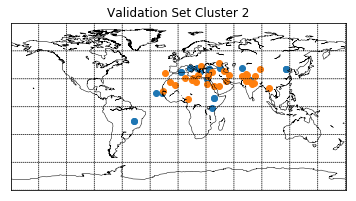

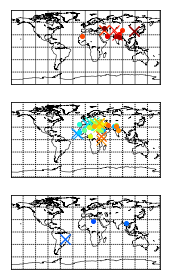

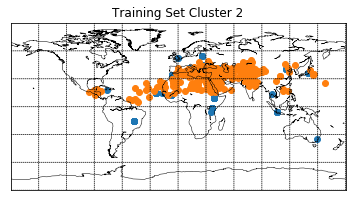

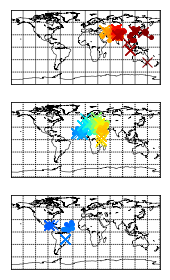

Finish Training NN for Cluster 2
Epoch 1/55
100/100 [==============================] - 19s 193ms/step - loss: 113.9125
Epoch 2/55
100/100 [==============================] - 0s 821us/step - loss: 71.3076
Epoch 3/55
100/100 [==============================] - 0s 710us/step - loss: 43.5004
Epoch 4/55
100/100 [==============================] - 0s 761us/step - loss: 39.2762
Epoch 5/55
100/100 [==============================] - 0s 751us/step - loss: 36.0487
Epoch 6/55
100/100 [==============================] - 0s 731us/step - loss: 35.4951
Epoch 7/55
100/100 [==============================] - 0s 781us/step - loss: 32.9955
Epoch 8/55
100/100 [==============================] - 0s 771us/step - loss: 32.2218
Epoch 9/55
100/100 [==============================] - 0s 741us/step - loss: 30.3683
Epoch 10/55
100/100 [==============================] - 0s 771us/step - loss: 29.5550
Epoch 11/55
100/100 [==============================] - 0s 690us/step - loss: 28.8079
Epoch 12/55
100/100 [==================

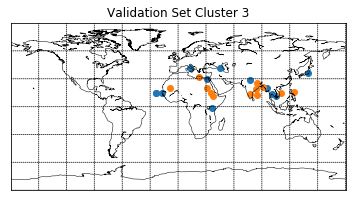

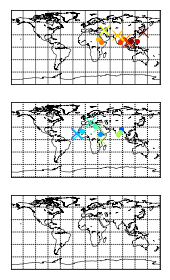

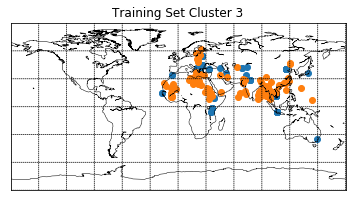

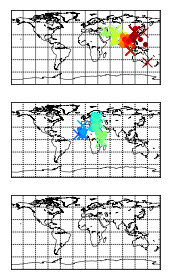

Finish Training NN for Cluster 3
Finish Training
Number of test data points is 225
Cluster Number in test data 4
Start predict cluster 2
Init ok
modelOk
Ave Dist in Cluster 2 is 3978.7343190346746


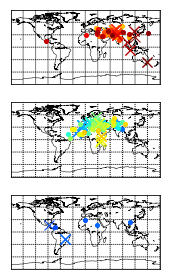

Start predict cluster 1
Init ok
modelOk
Ave Dist in Cluster 1 is 4430.6837543138745


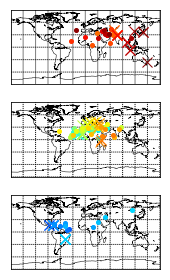

Start predict cluster 0
Init ok
modelOk
Ave Dist in Cluster 0 is 2661.538942172459


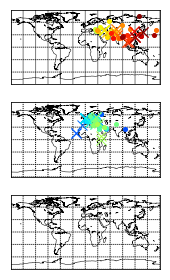

Start predict cluster 3
Init ok
modelOk
Ave Dist in Cluster 3 is 2979.18371687072


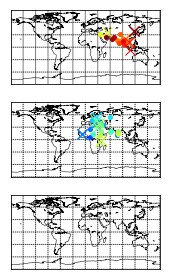

Finish Test
Average Distance is 3706.3410724126998


In [14]:
aveDist, predictArray, trueYarray = trainTest(4, lambd = 0.3, epochNum = 55, batchSize = 10)

In [ ]:
def saveTrainTestCluster(clusterNum):
    train_data = np.genfromtxt('train0.8.txt')
    criticalFind = list(range(68))
    covtype = 'full'
    classifyModel, classDic = seperateCluster(clusterNum, train_data, covtype, criticalFind)
    for i in classDic:
        np.savetxt('train' + str(i) + '.txt', classDic[i])
    for i in classDic:
        np.savetxt('train' + str(i) + '.txt', classDic[i])
        
    
    testData = np.genfromtxt('test0.2.txt')    
    n = testData.shape[0]

    testCluster = {}
    
    for i in range(n):
        clusterInd = int(classifyModel.predict(testData[i, criticalFind].reshape((1, len(criticalFind))))[0])
        if clusterInd not in testCluster:
            testCluster[clusterInd] = [testData[i, :]]
        else:
            testCluster[clusterInd].append(testData[i, :])
    for ind in testCluster:
        np.savetxt('test' + str(ind) + '.txt', testCluster[ind])

In [ ]:
def predictClusterSep(clusterNum):
    totalDist = 0
    totalSize = 0
    for i in range(1, 2):
        print(i)
        modelfile = 'cluster' + str(i) + '.h5'
        model = load_model(modelfile, custom_objects={'_loss_tensor': _loss_tensor})
        testfile = 'test' + str(i) + '.txt'
        testData = np.loadtxt(testfile)
        size = testData.shape[0]
        totalSize += size
        X = testData[:, :-2]
        Y = testData[:, -2:]
        Yp = model.predict(X)
        dist = 0
        for j in range(size):
            dist += haversine(Y[i, :], Yp[i, :])
        aveDist = dist / size
        totalDist += dist
        print('cluster ' + str(i) + ' has ' + str(size) + ' points, average Distance is ' + str(aveDist))
        
        bm=Basemap()
        bm.drawcoastlines(linewidth=0.5)
        bm.drawmeridians(np.arange(0,360,30))
        bm.drawparallels(np.arange(-90,90,30))


    #     plt.scatter(Y[:,1],Y[:,0])       # plot training location
        plt.scatter(Y[:, 1], Y[:, 0], label = 'True')   # plot validation location
        plt.scatter(Yp[:,1],Yp[:,0], label = 'Predicted')
        plt.title('Test Set Cluster ' + str(i))
        plt.legend(loc = 'best')
        plt.savefig('cluster' + str(i) +  'Test.pdf', bbox_inches = 'tight')
        plt.show()
        
    totalAve = totalDist / totalSize
    print('Overall Average Distance is ' + str(totalAve))


In [34]:
def _loss_tensor(y_true, y_pred):
    #y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    #out=(y_true - y_pred)**2-bimix_gauss.prob(y_pred).eval(session=sess)
    B=np.genfromtxt('map_gaussian_mixture.txt',delimiter=',')
    ds = tf.contrib.distributions
    mix = list(B[:,-1])
    sigma=10.
    myc=[ds.MultivariateNormalDiag([B[0,0],B[0,1]], [B[0,2]/sigma,B[0,2]/sigma])]

    for i in range(59):
        myc.append(ds.MultivariateNormalDiag([B[i+1,0],B[i+1,1]], [B[i+1,2]/sigma,B[i+1,2]/sigma]))

    bimix_gauss = ds.Mixture(
      cat=ds.Categorical(probs=mix),
      components=myc)

    split0, split1 = tf.split(y_pred, num_or_size_splits=2, axis=-1)
    split3, split4 = tf.split(y_true, num_or_size_splits=2, axis=-1)
    out=6371*tf.asin(K.sin((split1 - split4)/(180*math.pi))**2+
                     K.cos(split1/(180*math.pi))*K.cos(split4/(180*math.pi))*K.sin((split3-split0)*0.5/(180*math.pi))**2)



#         out=(y_true - y_pred)**2
    out2=-0.3 * bimix_gauss.prob(y_pred)#.eval(session=sess)
    #out = -(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred))
    return K.mean(out, axis=-1)+K.mean(out2, axis=-1)

In [36]:
clusterIndex = 0
trainClusterFile = 'cluster' + str(clusterIndex) + 'train.txt'
clusterTrainData = np.loadtxt(trainClusterFile)
model = nnCluster(clusterTrainData, clusterIndex, lambd = 0.1, epochNum = 55, batchSize = 10, trainRatio = 0.9)
model.save('clusterWhole' + str(clusterIndex) + '.h5')

testfile = 'test' + str(clusterIndex) + '.txt'
testData = np.loadtxt(testfile)


# TEST

clusterSize = testData.shape[0]
model = load_model(modelfile, custom_objects={'_loss_tensor': _loss_tensor})

for i in range(clusterSize):
    testx = clusterData[i, :-2].reshape((1, 68))

    ypred = amodel.predict(testx)[0, :]
    y = clusterData[i, -2:]
    clusterPred.append(ypred)
    clusterTrueY.append(y)
    clusterDist += haversine(y , ypred)

clusterPred = np.vstack(clusterPred)
clusterTrueY = np.vstack(clusterTrueY)



clusterAve = clusterDist / clusterSize
print('Ave Dist in Cluster ' + str(ind) + ' is ' + str(clusterAve))
plotPrediction(clusterTrueY, clusterPred, ind, category = 'Test')



FileNotFoundError: [Errno 2] No such file or directory: 'cluster0train.txt'